In [4]:
import gym
import numpy as np
from tensorboardX import SummaryWriter
from time import time
from tqdm import tqdm, trange

In [5]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)
import moviepy.editor as mpy

In [6]:
def save_video(writer, name):
    done = False
    frames = []
    state = env.reset()
    while not done:
        action = np.argmax(model.predict(np.array([state])))
        new_state, reward, done, _ = env.step(action)
        frames.append(env.render(mode = 'rgb_array'))
        state = new_state
    frames = np.array(frames)
    video = np.array(frames).reshape((1, )+frames.shape)
    writer.add_video(name, np.rollaxis(video, 4, 2), fps=20)
    writer.flush()

In [7]:
import gym
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD

Using TensorFlow backend.


In [8]:
env = gym.make('MountainCar-v0')

In [9]:
def get_model(lr=0.001):
    model = Sequential()
    model.add(Dense(100, input_shape=env.observation_space.shape))
    model.add(Dense(env.action_space.n))
    model.compile(Adam(lr), loss='mse')
    return model

In [10]:
model = get_model()
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 603
Trainable params: 603
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Parameters
env = gym.make('MountainCar-v0')
env.seed(1)
steps = 200
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 1000
max_position = -0.4
learning_rate = 0.0001
successes = 0
position = []
start_time = int(time())
writer = SummaryWriter(f'logs/deep/{start_time}_{learning_rate}_{gamma}')

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        # Uncomment to render environment
        #if episode % 100 == 0 and episode > 0:
        #    env.render()
        
        # Get first action value function
#         Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        Q = model.predict(np.array([state]))[0]
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            action = np.argmax(Q)
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)
        
        # Adjust reward based on car position
        reward = state_1[0] + 0.5
        
        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
            writer.add_scalar('data/max_position', max_position, episode)
        
        # Adjust reward for task completion
        if state_1[0] >= 0.5:
            reward += 1
        
        # Find max Q for t+1 state
        Q1 = model.predict(np.array([state_1]))[0]
        maxQ1 = np.max(Q1)
        
        # Create target Q value for training the policy
        Q_target = Q.copy()
        Q_target[action] = reward + maxQ1*gamma
        
        
        hist = model.fit(np.array([state]), np.array([Q_target]), verbose=0)
        # Calculate loss
        loss = hist.history['loss'][0]
        
        episode_loss += loss
        episode_reward += reward
        
        if done:
            if state_1[0] >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .95
                writer.add_scalar('data/epsilon', epsilon, episode)

                # Adjust learning rate
#                 scheduler.step()
                #optimizer.param_groups[0]['lr'] = max(optimizer.param_groups[0]['lr'], 1.0e-4)
#                 writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                # Record successful episode
                successes += 1
                writer.add_scalar('data/cumulative_success', successes, episode)
                writer.add_scalar('data/success', 1, episode)
            
            elif state_1[0] < 0.5:
                writer.add_scalar('data/success', 0, episode)
            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            writer.add_scalar('data/episode_loss', episode_loss, episode)
            writer.add_scalar('data/episode_reward', episode_reward, episode)
#             weights = np.sum(np.abs(policy.l2.weight.data.numpy()))+np.sum(np.abs(policy.l1.weight.data.numpy()))
#             writer.add_scalar('data/weights', weights, episode)
            writer.add_scalar('data/position', state_1[0], episode)
            position.append(state_1[0])

            break
        else:
            state = state_1
            
writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

  0%|          | 0/1000 [00:00<?, ?it/s]

Instructions for updating:
Use tf.cast instead.


  8%|▊         | 75/1000 [00:27<05:15,  2.94it/s]

KeyboardInterrupt: 

In [13]:
EPISODES = 1000
LEARNING_RATE = 0.001
model = get_model(LEARNING_RATE)
DISCOUNT = 0.99
epsilon = 1
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
ep_return = 0
steps = 0
start_time = int(time())
writer = SummaryWriter(f'logs/deep/{start_time}_{LEARNING_RATE}_{DISCOUNT}')

best_return = -np.infty

for episode in range(EPISODES):
    state = env.reset()
    done = False
    
    print(f'\r{episode}', end='')
    
    while not done:
        Q = model.predict(np.array([state]))[0]
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(Q)
        else:
            # Get random action
            action = np.random.randint(0, env.action_space.n)


        new_state, reward, done, _ = env.step(action)
        reward = new_state[0] + 0.5
        if new_state[0] >= 0.5:
            reward += 1
        
        ep_return += reward
        steps += 1

        # If simulation did not end yet after last step - update Q table
        if not done:
            Q1 = model.predict(np.array([new_state]))[0]
            # Maximum possible Q value in next step (for new state)
            maxQ1 = np.max(Q1)

            Q[action] = reward + DISCOUNT * maxQ1
            hist = model.fit(np.array([state]), np.array([Q]), verbose=0)
            

        # Simulation ended (for any reason) - if goal position is achived - update Q value with reward directly
        else:
            if new_state[0] >= env.goal_position:
                reward = 0
                Q[action] = reward
                hist = model.fit(np.array([state]), np.array([Q]), verbose=0)
            
            if ep_return>best_return:
                save_video(writer, f'{start_time}_{episode}_{ep_return}')
                best_return = ep_return
                
            writer.add_scalar('return', ep_return, episode)
            writer.add_scalar('step', steps, episode)
            writer.add_scalar('epsilon', epsilon, episode)
            
            ep_return = 0
            steps = 0

        state = new_state

    # Decaying is being done every episode if episode number is within decaying range
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value


env.close()

0

NoSuchDisplayException: Cannot connect to "None"

In [55]:
normailized_q_table = (q_table - q_table.min())
normailized_q_table = normailized_q_table/normailized_q_table.max()

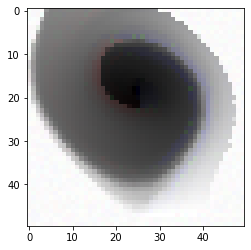

In [56]:
from matplotlib import pyplot as plt
plt.imshow(normailized_q_table)

In [57]:
normailized_q_table.max(), normailized_q_table.min()

(1.0, 0.0)

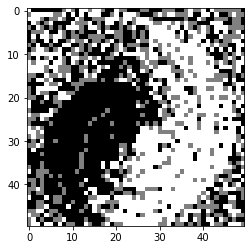

In [61]:
plt.imshow(np.argmax(q_table, axis=2)[::-1], cmap='gray')

In [81]:
x = np.arange(env.observation_space.low[0], env.observation_space.high[0], discrete_os_win_size[0])
y = np.arange(env.observation_space.low[1], env.observation_space.high[1], discrete_os_win_size[1])
xx, yy = np.meshgrid(x, y, sparse=False)

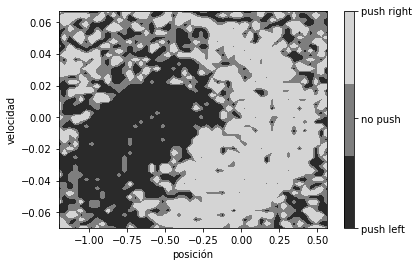

In [137]:
cs = plt.contourf(xx, yy, np.argmax(q_table, axis=2)/2, levels=[0, 0.33, 0.66, 1], cmap='gray')  #, vmin=0, vmax=2
plt.xlabel('posición')
plt.ylabel('velocidad')
cbar = plt.colorbar()
cbar.set_ticks(np.array([0, 1, 2])/2)
cbar.set_ticklabels(['push left', 'no push', 'push right'])
#plt.clabel(cs, fmt='%2.1f', colors='w', fontsize=14)
plt.show()